In [2]:
import nltk
nltk.download('punkt_tab')  # Добавляем скачивание punkt_tab
nltk.download('punkt')      # Уже есть, но оставим для надёжности
nltk.download('stopwords')

import tensorflow_datasets as tfds
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Загружаем датасет IMDb
ds, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset = ds['train']

# Преобразуем в список словарей
data = []
for text_tensor, label_tensor in train_dataset:
    text = text_tensor.numpy().decode('utf-8')
    label = int(label_tensor.numpy())
    data.append({'text': text, 'label': label})

# Создаём DataFrame
train_data = pd.DataFrame(data)

# Очистка текста
stop_words = set(stopwords.words('english'))
def clean_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return ' '.join(tokens)

train_data['cleaned_text'] = train_data['text'].apply(clean_text)
print(train_data[['text', 'cleaned_text', 'label']].head())

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.R97GNC_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.R97GNC_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.R97GNC_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
                                                text  \
0  This was an absolutely terrible movie. Don't b...   
1  I have been known to fall asleep during films,...   
2  Mann photographs the Alberta Rocky Mountains i...   
3  This is the kind of film for a snowy Sunday af...   
4  As others have mentioned, all the women that g...   

                                        cleaned_text  label  
0  absolutely terrible movie lured christopher wa...      0  
1  known fall asleep films usually due combinatio...      0  
2  mann photographs alberta rocky mountains super...      0  
3  kind film snowy sunday afternoon rest world go...      1  
4  others mentioned women go nude film mostly abs...      1  


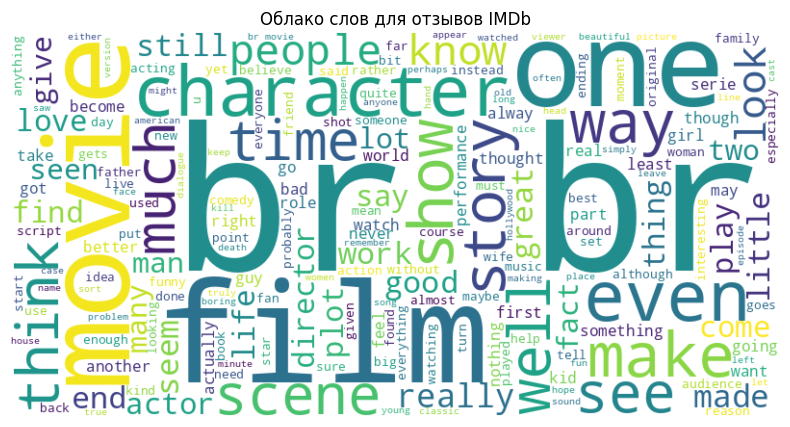

In [3]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import plotly.express as px

# Облако слов
all_text = ' '.join(train_data['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов для отзывов IMDb')
plt.show()

# Гистограмма длины отзывов
train_data['text_length'] = train_data['cleaned_text'].apply(lambda x: len(x.split()))
fig = px.histogram(train_data, x='text_length', color='label', title='Распределение длины отзывов')
fig.show()

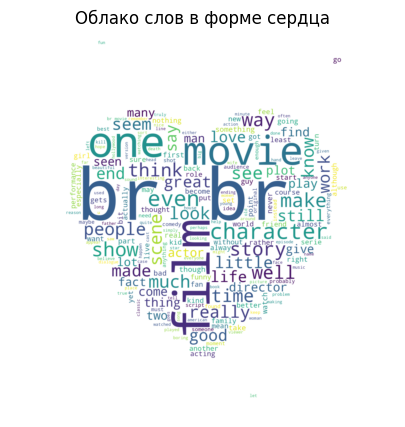

In [17]:
from wordcloud import WordCloud
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Создаём маску в форме сердца (нужна картинка сердца в PNG с прозрачным фоном)
heart_mask = np.array(Image.open("heart.png"))

# Облако слов
all_text = ' '.join(train_data['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white', mask=heart_mask, contour_color='white', contour_width=1).generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов в форме сердца')
plt.show()

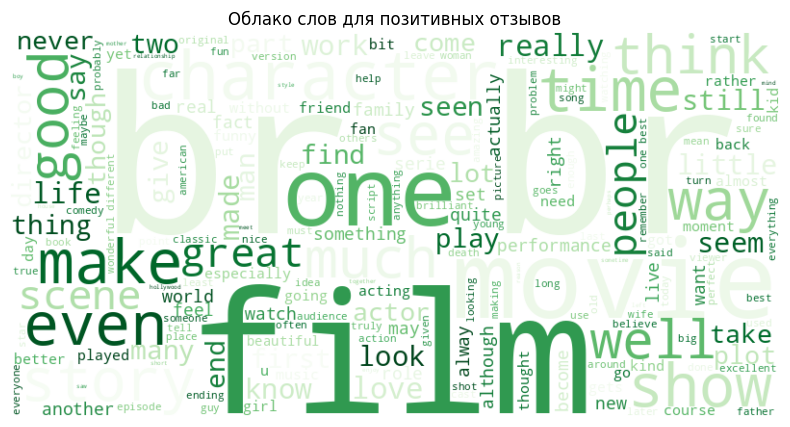

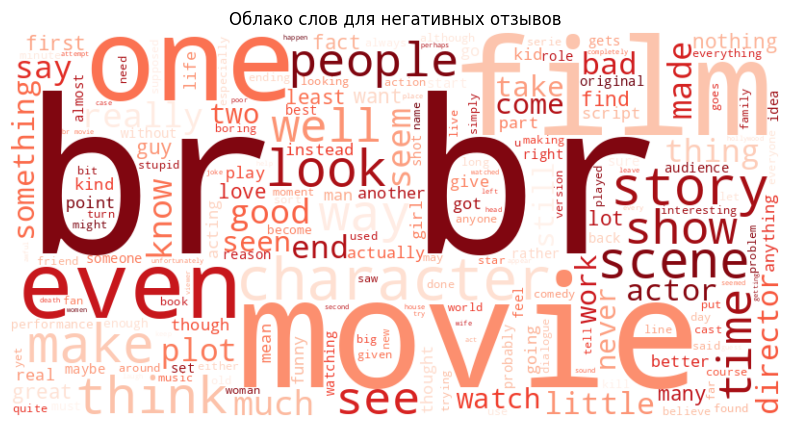

In [18]:
# Позитивные отзывы
positive_text = ' '.join(train_data[train_data['label'] == 1]['cleaned_text'])
wordcloud_pos = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов для позитивных отзывов')
plt.show()

# Негативные отзывы
negative_text = ' '.join(train_data[train_data['label'] == 0]['cleaned_text'])
wordcloud_neg = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов для негативных отзывов')
plt.show()

In [19]:
import plotly.express as px
from collections import Counter

# Считаем частоту слов
all_words = ' '.join(train_data['cleaned_text']).split()
word_freq = Counter(all_words).most_common(50)  # Топ-50 слов
word_df = pd.DataFrame(word_freq, columns=['word', 'freq'])

# Интерактивный график
fig = px.bar(word_df, x='freq', y='word', title='Топ-50 слов в отзывах', orientation='h')
fig.show()

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Векторизация текста
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(train_data['cleaned_text'])
y = train_data['label']

# Делим данные
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучаем модель
model = LogisticRegression()
model.fit(X_train, y_train)

# Предсказываем
y_pred = model.predict(X_test)

# Оцениваем
print("Точность классификации отзывов:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nПодробный отчёт:")
print(classification_report(y_test, y_pred))

Точность классификации отзывов:
Accuracy: 0.88

Подробный отчёт:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      2576
           1       0.86      0.90      0.88      2424

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000

